# Hechos estilizados del ciclo económico de Estados Unidos
En este cuaderno vamos a introducir estadísticos clave para estudiar las características del ciclo económico en Estados Unidos, desde 1960 hasta 2007. De esta forma garantizamos que sea poco probable que persistan efectos cíclicos de la guerra de la segunda guerra mundial y la guerra de Korea, que supusieron enormes incrementos del gasto público y destrucción de maquinaria bélica o eventos mayores como Pearl Harbour, aunque probablemente la importancia macroeconómica de estos eventos es pequeña.

Iniciamos cargando librerías...

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

Cargamos datos de contabilidad nacional que han sido obtenidos de el [Bureau of Economic Análisis, BEA](https://apps.bea.gov/iTable/index_nipa.cfm) y datos sobre personal ocupado en el sector privado y público del [Bureau of Labor Statistics](https://www.bls.gov). Además obtenemos información sobre horas de trabajo trimestrales, aunque sólo hay información disponible desde el segundo trimestre de 2006.

In [56]:
# We load price and quantity information 
tempq = pd.read_excel('NIPA_usa.xlsx', sheet_name='Quant')
tempp = pd.read_excel('NIPA_usa.xlsx', sheet_name='Price')

# And we also load employment information, both total and private
## total employment
emp_temp = pd.read_excel('laborUS.xlsx', sheet_name='Private employment')
emp = emp_temp.set_index('Period').stack().reset_index().rename(
    columns={0:'Emp'}
)
idx = pd.date_range('1947-01-01', periods=len(emp['Emp']), freq='Q')
emp = emp.set_index(idx)

## public employment
empg_temp = pd.read_excel('laborUS.xlsx', sheet_name='Public employment')
empg = empg_temp.set_index('Period').stack().reset_index().rename(
    columns={0:'Empg'}
)
idx = pd.date_range('1947-01-01', periods=len(empg['Empg']), freq='Q')
empg = empg.set_index(idx)

## hours of work
hours_temp = pd.read_excel('laborUS.xlsx', sheet_name='Total hours private')
hours = hours_temp.set_index('Period').stack().reset_index().rename(
    columns={0:'Hours'}
)
idx = pd.date_range('2006-01-01', periods=len(hours['Hours']), freq='Q')
hours = hours.set_index(idx)

labor = pd.merge(
    empg['Empg'],
    emp['Emp'],
    left_index=True,
    right_index=True
)

labor = pd.merge(
    labor,
    hours['Hours'],
    left_index=True,
    right_index=True,
    how='outer'
)

In [57]:
# First we give the data a proper structure
quant = tempq.set_index(['Variables']).T.reset_index()
price = tempp.set_index(['Variables']).T.reset_index()
# Then we create a time index from 1960-Q1 to 2022-Q1
idx = pd.date_range('1947-01-01', periods=len(quant['PC']), freq='Q')

quant = quant.set_index(idx)
price = price.set_index(idx)

usa = pd.merge(
    quant,
    price,
    left_index=True,
    right_index=True
).drop(columns=['index_x', 'index_y'])

usa = pd.merge(
    usa,
    labor,
    left_index=True,
    right_index=True
)

Vamos a suponer conceptualmente que la producción de valor de una economía se realiza en un único sector y que el numerario es el deflactor implícito del consumo privado (de bienes no duraderos). Podrían haberse usado otros deflactores como el índice de precios al consumo. La restricción de recursos de la economía por el lado del gasto puede escribirse como
$$P_{ct}c_{t}+P_{it}i_{t}+P_{gt}g_{t}=P_{yt}y_{t}=GDP_{t}$$ then $$c_{t}+\frac{P_{it}}{P_{ct}}i_{t}+\frac{P_{gt}}{P_{ct}}g_{t}=\frac{P_{yt}}{P_{ct}}y_{t}$$
El problema de este enfoque es que no estamos comparando la evolución de cantidades reales, sino la relación entre el valor del consumo, la inversión y el PIB, cuando una fracción significativa del movimiento en el valor agregado se produce a través de cambios en precios, como muestran Greenwood et al. (1997) documentando una caida sistemática del precio de los bienes de inversión respecto de los bienes de consumo. 

En nuestra economía vamos a suponer que el consumo duradero es una forma de inversión. Es una práctica común adaptar los datos de la contabilidad nacional para que sean comparables con los resultados del modelo neoclásico de crecimiento, que en el fondo es una teoría sobre el comportamiento de los agregados de dicho sistema de cuentas. Típicamente se considera que el PIB de la contabilidad nacional que debe considerarse es la suma del consumo privado y la inversión privada, ya que el MNC es una economía cerrada sin gobierno en su versión más sencilla.

In [61]:
# We first define GDP 
simple = pd.DataFrame()
simple['Y'] = usa['PC'] + usa['PI'] + usa['GI'] + usa['GC_GD']

# We deal with the philosophical question of what is 
# investment. Given that in the NGM there is a representative
# agent that owns the firms, durable consumption may be prefec-
# ly considered an investment
simple['I'] = usa['PI'] + usa['PC_GD']
simple['C'] = usa['PC'] - usa['PC_GD']
simple['G'] = usa['GI'] + usa['GC_GD']

# We create real variables
simple['rI'] = simple['I']/usa['P_PC_NDG']*100
simple['rC'] = simple['C']/usa['P_PC_NDG']*100
simple['rG'] = simple['G']/usa['P_PC_NDG']*100
simple['rY'] = simple['Y']/usa['P_PC_NDG']*100

# We add some other variables to illustrate some
# important features
simple['rCDUR'] = usa['PC_GD']/usa['P_PC_NDG']*100
simple['P_PC_DG'] = usa['P_PC_DG']
simple['P_PC_NDG'] = usa['P_PC_NDG']
simple['P_PI'] = usa['P_PI']
simple['rPI'] = usa['PI']/usa['P_PI']*100
simple['Emp'] = usa['Emp']
simple['Empg'] = usa['Empg']
simple['POP'] = usa['POP']
simple['CKFP'] = usa['CKFP']/usa['P_PC_NDG']*100
simple['CKFG'] = usa['CKFG']/usa['P_PC_NDG']*100

Vamos a considerar que el capital público produce servicios de naturaleza pública que pueden cuantificarse en nuestra contabilidad imputando una rentabilidad sobre una serie del acervo de capital público. También es necesario considerar el valor de los servicios que proporciona tener cierto acervo de bienes de consumo duradero. Por ese motivo calculamos series de capital público y el acervo de bienes duraderos.

Hay dos formas de calcular el acervo de capital de datos de contabilidad nacional. La primera se basa en un método descrito en Hall & Jones (1998) donde se emplea el método de inventario permanente, donde el capital el periodo siguiente puede escribirse como 
$$K_{t}=(1-\delta)K_{t-1}+I_{t}$$
donde $\delta K_{t-1}$ es la depreciación del capital que estemos considerando e $I_{t}$ es la inversión en ese capital o gasto en consumo duradero. Si conocemos el valor de $\delta$ y de $K_{0}$ podemos calcular el acervo de capital en cada periodo, lo que se hace de forma rutinaria en los análisis de contabilidad de crecimiento y desarrollo. El valor de $K_{0}$ se obtiene suponiendo que la economía se encuentra en la senda de crecimiento balanceado de la economía.
$$K_{0}=\frac{I_{1}}{g+\delta}$$
donde $g$ es la tasa de crecimiento geométrica del PIB o de la inversión privada de la economía, dependiendo de si consideramos uno o varios sectores.

La segunda forma de estimar una serie de capital también se basa en el método de inventario permanente y fue propuesta por Kehoe et al. (xxxx). Consiste en estimar simultáneamente el valor de $\delta$ y $K_{0}$ directamente eligiendo dos momentos basados en el supuesto de que la economía se encuentra en su senda de crecimiento balanceado que podemos escribir como
$$\frac{1}{t_{2}-t_{1}}\sum^{t_{2}}_{t_{1}}\frac{\delta K_{t-1}}{PIB_{t}}=\frac{1}{t_{4}-t_{3}}\sum^{t_{4}}_{t_{3}}\frac{\delta K_{t-1}}{PIB_{t}}$$
es decir, si la economía se encuentra en la senda de crecimiento balanceado, la tasa de depreciación entre cualesquiera dos subperiodos respecto del PIB tiene que ser identica. Además
$$\frac{K_{0}}{PIB_{1}}=\frac{1}{t_{6}-t_{5}}\sum^{t_{6}}_{t_{5}}\frac{K_{t-1}}{PIB_{t}}$$
la ratio de capital producto inicial debe ser igual a la ratio de capital producto promedio en cualquier subperiodo. No existe ningún procedimiento correcto para elegir subperiodos más que el sentido común. Por ejemplo, si el supuesto de identificación es que la economía se encuentra en la senda de crecimiento balanceado no elegiríamos subperiodos que contuvieran una gran recesión o únicamente una recesión. 

Vamos a implementar el método de Hall, tomando el valor de la tasa de depreciación trimestral para los bienes duraderos de .05 y quizás amerite de una breve explicación. Greenwood et al. (2000) calibra un valor para la tasa de depreciación de los equipos de .035 y McGrattan et al. (1995) estima una tasa de depreciación de .02 para el capital de los hogares. Si vemos cifras recientes, NIPA estima que la depreciación imputada anualmente representó el 59% del consumo duradero en 2020, lo que apunta a que la tasa de depreciación es elevada, salvo que incluyamos bienes inmuebles (deberiamos hacerlo). Todas estas consideraciones afectan a la elección de rentabilidad. Si tenemos un modelo en mente con un solo sector, la rentabilidad esperada, ajustada por depreciación y riesgo, de los bienes duraderos debe coincidir con la de un bono del gobierno de vencimiento trimestral, que tiene una rentabilidad del 1% aproximadamente... y podríamos hacer más larga la discusión.

In [83]:
# We should try to set interest rates through some arbitrage condition
# but it is hard to determine what should be the returns of public
# capital or durable consumption compared to, say, treausary bonds
ret = .015 # quarterly return
delta = .05 # We assume that depreciation of durables is relatively large... 
simple['KDUR'] = np.nan
kdur=np.zeros(len(simple['rCDUR']))
kdur[0] = simple.loc['1947-03-31', 'rCDUR']/(ret+delta)
cdur=simple['rCDUR'].values
for t in range(1, len(simple['rCDUR'])):
    kdur[t] = (1.0-delta)*kdur[t-1]+cdur[t]
simple['KDUR'] = kdur
# Durable consumption generate returns through private
# consumption so we will add this service to private
# consumption as well
simple['rC'] = simple['rC'] + ret*simple['KDUR'] 
simple['rY'] = simple['rY'] + ret*simple['KDUR'] 

ret = .01
delta = .02
# We also compute a series of government capital because we are going to
# impute the service that public capital gives to the economy
simple['KPUB'] = np.nan
kpub=np.zeros(len(simple['rG']))
kpub[0] = 3.8*simple.loc['1947-03-31', 'rG']/(ret+delta)
gdur=simple['rG'].values
for t in range(1, len(simple['rG'])):
    kpub[t] = (1.0-delta)*kpub[t-1]+cdur[t]
simple['KPUB'] = kpub

# We use the rate of return to impute income to GDP
## This is consumption at the same time
simple['rY'] = simple['rY'] + ret*simple['KPUB'] 

Con esta información podemos representar gráficamente las series de capital público y consumo duradero respecto al PIB real privado e imputado.

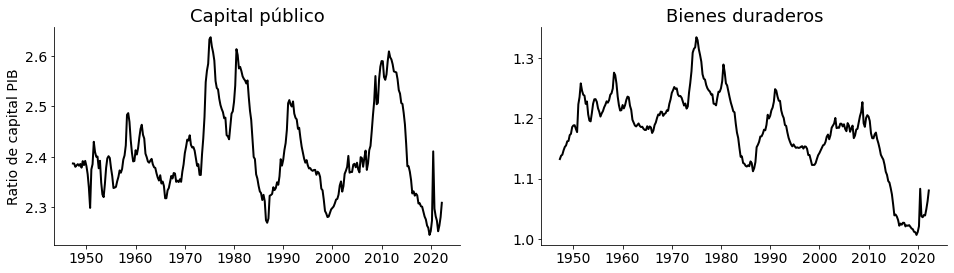

In [84]:
kgy = simple['KPUB']/simple['rY']
cdy = simple['KDUR']/simple['rY']

fig, ax = plt.subplots(1, 2, figsize=(16,4))

ax[0].plot(kgy, color='black', linewidth=2)
ax[1].plot(cdy, color='black', linewidth=2)
ax[0].set_ylabel('Ratio de capital PIB', fontsize=14)
#ax[0].set_ylim(1.5, 3)
#ax[1].set_ylim(.5, 2)
ax[0].set_title('Capital público', fontsize=18)
ax[1].set_title('Bienes duraderos', fontsize=18)
for axis in ax:
    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False) 
    axis.tick_params(axis='x', labelsize=14)
    axis.tick_params(axis='y', labelsize=14)    

Vemos que la ratio de capital publico PIB es bastante estable desde 1947 y la serie de bienes duraderos respecto de PIB privado también es estable hasta 1980, pero muestra una pendiende decreciente, probablemente debido al cambio en la calidad de los equipos industriales y domésticos que se manifiesta en una caída secular del precio relativo ajustado por los cambios de calidad (ver Gordon (1990)) superior al 3% anual. 

## Hechos estilizados de Kaldor
Vamos a comprobar primero, antes de documentar las características del ciclo económico de Estados Unidos, si se satisfacen los hechos estilizados de Kaldor: una tasa de crecimiento del PIB por habitante aproximandamente constante en el tiempo, unas ratios de consumo e inversión respecto del PIB constantes en el tiempo y una ratio de capital producto también constante a largo plazo. Empezamos representando gráficamente nuestro PIB privado imputado por habitante.

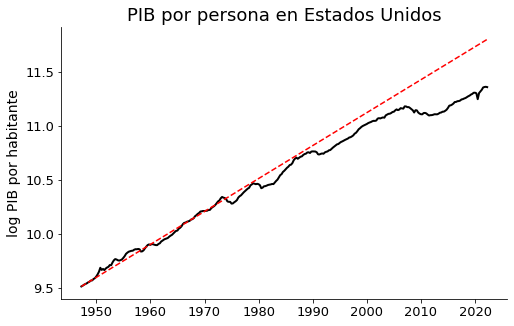

In [218]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))
dum = (simple.index < '2007-12-01')
x = simple['rY']/simple['POP']

y = x[dum]
gr = (x[-1]/x[0])**(1/(len(y)-1))

trend = np.zeros(len(x))
trend[0]= np.log(y[0]*1.0e+6)
for t in range(1,len(x)):
    trend[t]=trend[t-1]+np.log(gr)

simple['trend']=trend    
ax.plot(
    np.log(x*1.0e+6), 
    linewidth=2,
    color='black'
)
ax.plot(simple['trend'], linestyle='--', color='red')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel(
    'log PIB por habitante',
    fontsize=14
)
ax.set_title('PIB por persona en Estados Unidos', fontsize=18)
ax.tick_params(axis='x', labelsize=13)
ax.tick_params(axis='y', labelsize=13);

# Vamos a añadir una línea de regresión al gráfico

Vemos que desde 1947 hasta 1980, el crecimiento del PIB por habitante es estable pero empieza a crecer más lento sobretodo después de las dos crisis petroleras y a partir de la década de los 80-90. No obstante podríamos decir que el crecimiento del PIB es relativamente estable. La gráfica también nos permite distinguir fluctuaciones cíclicas, de grandes recesiones y de cambios estructurales, temas de los que hablaremos más adelante.

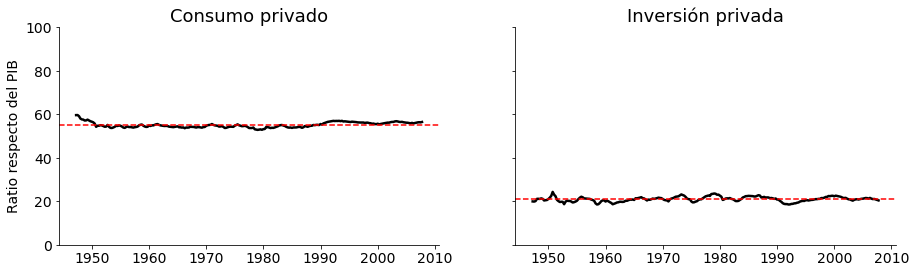

In [219]:
fig, ax = plt.subplots(1, 2, figsize=(15,4), sharey=True)
x = simple.loc[dum, 'rC']/simple.loc[dum, 'rY']*100
ax[0].plot(x, linewidth=2.5, color='black')
ax[0].set_ylim(0, 100)
ax[0].axhline(
    x.mean(), 
    linestyle='--', 
    linewidth=1.5,
    color='red'
)
x = simple.loc[dum, 'rI']/simple.loc[dum, 'rY']*100
ax[1].plot(x, linewidth=2.5, color='black')
ax[1].set_ylim(0, 100)
ax[1].axhline(
    x.mean(), 
    linestyle='--', 
    linewidth=1.5,
    color='red'
)
for axis in ax:
    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)
    axis.tick_params(axis='x', labelsize=14)
    axis.tick_params(axis='y', labelsize=14)

ax[0].set_ylabel('Ratio respecto del PIB', fontsize=14)
ax[0].set_title('Consumo privado', fontsize=18)
ax[1].set_title('Inversión privada', fontsize=18);

donde pueden ver que una inspección visual situal al consumo privado de no duraderos en torno al 58% del PIB privado de la economía desde 1947 hasta justo antes de la Gran Recesión, al igual que con la inversión. Lo último que nos queda por comprobar es si el capital privado es relativamente estable en el tiempo, para lo que aplicamos el método de Hall usando las series de inversión privada que hemos construido.

In [220]:
simple['rK'] = np.nan
delta = .02
inv = simple['rI'].values
cap = np.zeros(len(simple['rI']))
cap[0]= .30*inv[0]/(ret+delta)

for t in range(1, len(inv)):
    cap[t] = (1.0-delta)*cap[t-1]+inv[t]/4

simple['rK'] = cap
alpha = .38

# To compute total factor productivity we are going to
# assume that employment is population to 
simple['tfp'] = simple['rY']/((simple['rK']**alpha)*(simple['Emp']**(1.0-alpha)))

Tras estos cálculos lo primero que podemos establecer es que la ratio de capital producto es "relativamente" constante

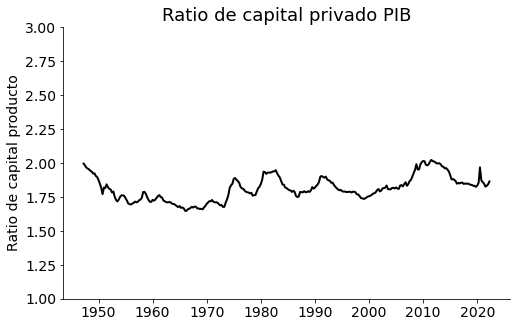

In [221]:
ky = simple['rK']/simple['rY']

fig, ax = plt.subplots(1, 1, figsize=(8,5))
#dum = (simple.index < '2007-12-01') & (simple.index > '1960-01-01')
ax.plot(
    ky, 
    linewidth=2,
    color='black'
)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel(
    'Ratio de capital producto',
    fontsize=14
)
ax.set_ylim(1, 3)
ax.set_title('Ratio de capital privado PIB', fontsize=18)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14);

y podemos ver también que la productividad total de los factores se encuentra altamente asociada a la evolución del PIB por habitante.

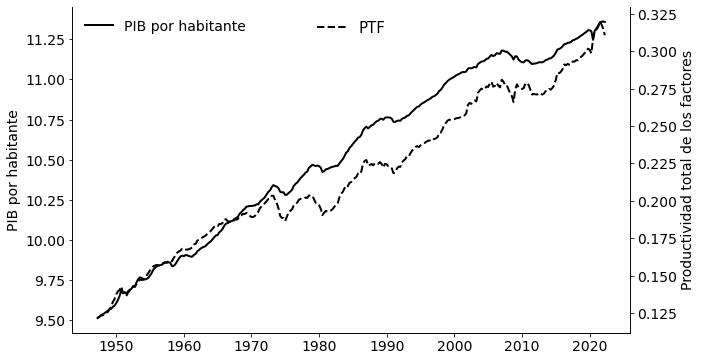

In [268]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
x = simple['rY']/simple['POP']*1.0e+6

ax.plot(np.log(x), linewidth=2, color = 'black')
axb = ax.twinx()
ax.spines['top'].set_visible(False)
axb.spines['top'].set_visible(False)
axb.plot(simple['tfp'], color = 'black', linewidth=2, linestyle='--')
ax.tick_params(axis='x',labelsize=14)
ax.tick_params(axis='y',labelsize=14)
axb.tick_params(axis='y',labelsize=14)
ax.set_ylabel('PIB por habitante', fontsize=14)
axb.set_ylabel('Productividad total de los factores', fontsize=14)
ax.legend(['PIB por habitante'], fontsize=14, frameon=False)
axb.legend(['PTF'], fontsize=15, frameon=False, loc='upper center');

Pueden ver que la productividad total de los factores se encuentra altamente asociada, no solo a largo plazo, sino a corto plazo también, lo que nos lleva a una pregunta casi filosófica: ¿qué distingue el corto, del medio, del largo plazo?. Los economistas afrontamos este problema como un problema de filtrado de frecuencias. Al igual que un DJ puede modular los agudos y los graves que escuchemos, nosotros podemos excluir fluctuaciones que sean diarias, mensuales, quinquenales, usando filtros (similares a los que utiliza su caja de mezclas) diseñados para excluir esas frecuencias. Los economistas usamos con frecuencia el filtro de Hodrick y Prescott (1997), aunque aún es objeto de disputa sobre si es un intrumento adecuado para eliminar tendencias o si, en su intento, cambia las propiedades estadísticas de las series como sostiene Hamilton (2017), postura que Hodrick (2020) intenta refutar. Veamos como usar el filtro de Hodrick Prescott, aunque no necesitamos programarlo porque ya está incluido en la librería de rutinas estadísticas `statsmodels`

>**El Filtro de Hodrick-Prescott (HP)**
<br>
Podemos escribir el filtro HP como un problema de minimización donde descomponemos una serie temporal $\{y_{t}\}^{T}_{t=1}$, donde $T$ es la longitud de la serie temporal que podemos descomponer linealmente en un componente cíclico $y^{c}_{t}$ y una tendencia $y^{\tau}_{t}$, tal que: $$y_{t}=y^{c}_{t}+y^{\tau}_{t}$$ resolviendo el siguiente problema 
$$\min_{y^{\tau}_{t}}\sum^{T}_{t=1}\left\{\left(y_{t}-y^{\tau}_{t}\right)^{2}+\lambda\left[(y^{\tau}_{t+1}-y^{\tau}_{t})-(y^{\tau}_{t}-y^{\tau}_{t-1})\right]^{2}\right\}$$
donde lambda es un parámetro que sirve para seleccionar lo que es corto o largo plazo, controlando la importancia que tiene la velocidad con la que cambia lo que llamamos tendencia --su aceleracion-- si elegimos un $\lambda$ muy alto estamos quedándonos con fluctuaciones de corto plazo porque permitimos que la tendencia pueda cambiar mucho y que el problema arroje aceleracione bajas. Si elegimos un lambda bajo, no le damos tanto peso y excluimos fluctuaciones de mayor frecuencia.

No vamos a entrar en los detalles técnicos del filtro, aunque puede mostrarse que es un filtro lineal, sino que vamos a aplicarlo directamente sobre las series

In [254]:
cyclical = pd.DataFrame()
for var in simple.columns:
    cyclical[f'{var}'], temp = sm.tsa.filters.hpfilter(
        np.log(simple.loc[dum, var]), 
        lamb = 3600
    )
    cyclical[f'{var}'] = (1+cyclical[f'{var}'])**4-1
    
# Guardamos la serie de productividad total de los factores 
# para posterior uso
cyclical['tfp'].to_csv('totalFactorProductivity.csv')
# Anualizamos el componente cíclico de la productividad 
# total de los factores

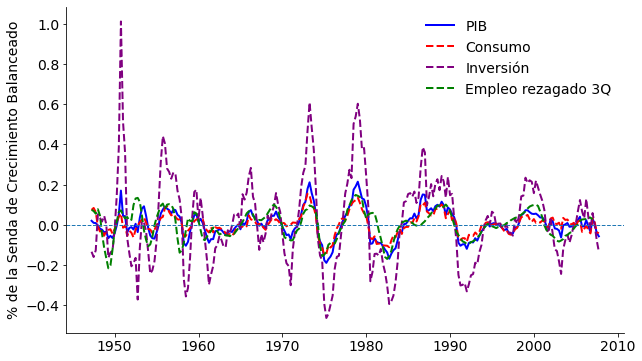

In [255]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(cyclical['rY'], linewidth=2, color='blue')
ax.plot(cyclical['rC'], linewidth=2, color='red', linestyle='--')
ax.plot(cyclical['rI'], linewidth=2, color='purple', linestyle='--')
ax.plot(cyclical['Emp'].shift(-3), linewidth=2, color='green', linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.axhline(0, linestyle='--', linewidth=1)
ax.set_ylabel('% de la Senda de Crecimiento Balanceado', fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.legend(['PIB', 'Consumo', 'Inversión', 'Empleo rezagado 3Q'], fontsize=14, frameon=False);

También podemos usar las series filtradas para mostrar que el consumo de bienes duraderos es más cercano a la inversión que al consumo, por lo menos en términos de su comportamiento cíclico.

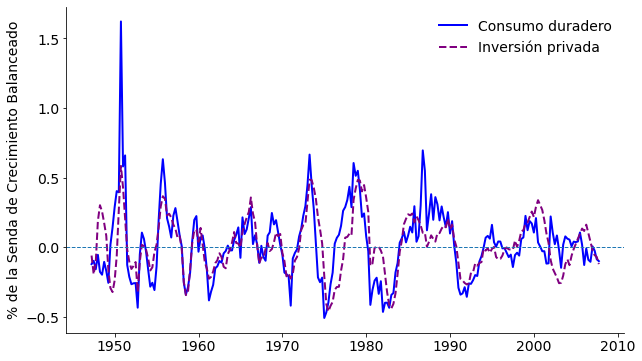

In [256]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
usa['PC_GD']

ax.plot(cyclical['rCDUR'], linewidth=2, color='blue')
ax.plot(cyclical['rPI'], linewidth=2, color='purple', linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.axhline(0, linestyle='--', linewidth=1)
ax.set_ylabel('% de la Senda de Crecimiento Balanceado', fontsize=14)
ax.legend(['Consumo duradero', 'Inversión privada'], fontsize=14, frameon=False);

Después de todo este trabajo vamos a caracterizar las propiedades cíclicas de las macromagnitudes de la economía de Estados Unidos antes de la Gran Recesión.

In [259]:
idx = [
    '$\sigma_{x}$', 
    '$\sigma_{x}$ rel. to $\sigma_{Y}$',
    '$\rho_{x,Y}$'
]
cols = ['Y', 'A', 'C', 'I', 'L']
bc = pd.DataFrame(
    index = idx,
    columns = cols
)
bc.loc['$\sigma_{x}$', 'Y'] = round(cyclical['rY'].std(), 3)
bc.loc['$\sigma_{x}$', 'A'] = round(cyclical['tfp'].std(), 3)
bc.loc['$\sigma_{x}$', 'C'] = round(cyclical['rC'].std(), 3)
bc.loc['$\sigma_{x}$', 'I'] = round(cyclical['rI'].std(), 3)
bc.loc['$\sigma_{x}$', 'L'] = round(cyclical['Emp'].std(), 3)

bc.loc['$\sigma_{x}$ rel. to $\sigma_{Y}$', 'Y'] = 1
bc.loc['$\sigma_{x}$ rel. to $\sigma_{Y}$', 'C'] = \
    cyclical['rC'].std()/bc.loc['$\sigma_{x}$', 'Y']
bc.loc['$\sigma_{x}$ rel. to $\sigma_{Y}$', 'A'] = \
    cyclical['tfp'].std()/bc.loc['$\sigma_{x}$', 'Y']
bc.loc['$\sigma_{x}$ rel. to $\sigma_{Y}$', 'I'] = \
    cyclical['rI'].std()/bc.loc['$\sigma_{x}$', 'Y']
bc.loc['$\sigma_{x}$ rel. to $\sigma_{Y}$', 'L'] = \
    cyclical['Emp'].std()/bc.loc['$\sigma_{x}$', 'Y']

bc.loc['$\sigma_{x}$ rel. to $\sigma_{Y}$', 'A'] = \
    round(bc.loc['$\sigma_{x}$ rel. to $\sigma_{Y}$', 'A'], 3)
bc.loc['$\sigma_{x}$ rel. to $\sigma_{Y}$', 'C'] = \
    round(bc.loc['$\sigma_{x}$ rel. to $\sigma_{Y}$', 'C'], 3)
bc.loc['$\sigma_{x}$ rel. to $\sigma_{Y}$', 'I'] = \
    round(bc.loc['$\sigma_{x}$ rel. to $\sigma_{Y}$', 'I'], 3)
bc.loc['$\sigma_{x}$ rel. to $\sigma_{Y}$', 'L'] = \
    round(bc.loc['$\sigma_{x}$ rel. to $\sigma_{Y}$', 'L'], 3)

bc.loc['$\rho_{x,Y}$', 'Y'] = 1
bc.loc['$\rho_{x,Y}$', 'C'] = round(cyclical[['rC', 'rY']].corr().values[0, 1], 3)
bc.loc['$\rho_{x,Y}$', 'A'] = round(cyclical[['tfp', 'rY']].corr().values[0, 1], 3)
bc.loc['$\rho_{x,Y}$', 'I'] = round(cyclical[['rI', 'rY']].corr().values[0, 1], 3)
bc.loc['$\rho_{x,Y}$', 'L'] = round(cyclical[['Emp', 'rY']].corr().values[0, 1], 3)
bc

,Y,A,C,I,L
$\sigma_{x}$,0.072,0.061,0.053,0.217,0.072
$\sigma_{x}$ rel. to $\sigma_{Y}$,1,0.85,0.734,3.014,0.995
"$\rho_{x,Y}$",1,0.706,0.928,0.919,0.569


Podemos destacar varios hechos estilizados que no solo se cumplen para Estados Unidos
- El consumo no duradero fluctua menos que la producción privada
    - Salvo en algunas economías, como la Mexicana, lo que aún es objeto de investigación
- La productividad total de los factores está altamente correlacionada con el consumo y la inversión
- El empleo fluctua en la misma magnitud que el PIB de la economía, aunque reacciona con algunos trimestres de rezago
    - Hay varias investigaciones en torno al fenómeno de "labor hoarding", por qué se produce y cuáles son las consencias para el comportamiento cíclico de la economía, que discutiremos más adelante en el curso

## La productividad total de los factores como proceso estocástico
Uno de los elementos más importantes del modelo RBC son los choques a la productividad total de los factores, ya que es la que genera el impulso en las versiones más sencillas del modelo. La mayoría de los trabajos de investigación estiman un proceso que es estacionario condicional a una tendencia determinista y que escribimos como
$$\log(A_{t+1})=(1+\hat{A})t + \rho\log(A_{t}) + \epsilon_{t+1}$$ where $$\epsilon_{t+1}\longrightarrow^{i.i.d.} N(0,\sigma^{2})$$
Hay variedad de investigaciones en el campo de la econometría de las series temporales que intenta determinar si el PIB es una serie con tendencia determinista o estocástica, pero vamos a abstraernos de una especificación más cuidadosa porque se sale de los objetivos de este curso.

In [260]:
from statsmodels.tsa.ar_model import AutoReg
res = AutoReg(
    np.log(simple['tfp'].dropna()), 
    lags = 1, 
    trend='ct',
    old_names=False
).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                    tfp   No. Observations:                  301
Model:                     AutoReg(1)   Log Likelihood                1030.051
Method:               Conditional MLE   S.D. of innovations              0.008
Date:                Tue, 02 Aug 2022   AIC                          -2052.101
Time:                        19:20:48   BIC                          -2037.286
Sample:                    06-30-1947   HQIC                         -2046.172
                         - 03-31-2022                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0640      0.020     -3.258      0.001      -0.102      -0.025
trend       8.276e-05   2.74e-05      3.018      0.003     2.9e-05       0.000
tfp.L1         0.9648      0.010     96.320      0.000       0.945       0.984
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0365           +0.0000j            1.0365            0.0000
-----------------------------------------------------------------------------
"""

Los dos parámetros de interés son la autocorrelación del proceso estocástico $\rho=.964$ y la desviación típica $\sigma = .008$, lo que implica una distribución log-normal estacionaria de la productividad con media $t\log(1+\hat{A})$ y varianza $\frac{\sigma^{2}}{1-\rho^{2}}=.0009$ que implica una desviación típica de .03.

Es necesario decir para concluir este cuaderno que la PTF es dificil de interpretar porque no es una medida de perturbaciones causales sino aquello que no pueden explicar capital y trabajo cuando son medidos de la mejor forma posible con los datos disponibles.

In [269]:
cyclical['epr'] = cyclical['Emp']-cyclical['POP']
cyclical[['rY', 'rC', 'rI', 'epr', 'tfp']].to_csv('nipaCyclical.csv')